# Imports and utility functions

In [3]:
import numpy as np
import time, glob, gc, os
import pandas as pd
import seaborn as sns
import tifffile
import matplotlib.pyplot as plt
import xarray as xr 

data_dir = '/data/srlab1/lakshay-yakir/uc/uc-data'
raw_dir = f'{data_dir}/raw'
out_dir = f'{data_dir}/10u'
os.makedirs(f'{raw_dir}', exist_ok=True)
os.makedirs(f'{out_dir}', exist_ok=True)

pixelsize = 0.75488 # in microns
downsample_factor = 10//pixelsize

k = 10
repname = f'pca_k={k}_harmony'

In [4]:
# read in channel names
channel_names_filepath = f'{data_dir}/channelNames.txt'
with open(channel_names_filepath, 'r') as file: 
    markers = file.read().splitlines()

# Read and understand one example file

In [62]:
# read in file
filename = "/data/srlab1/lakshay-yakir/uc/uc-data/raw/reg001_montage.tif"
pixels = tifffile.TiffFile(filename)
pixels_array = pixels.asarray().astype(np.uint16)
pixels_array.shape

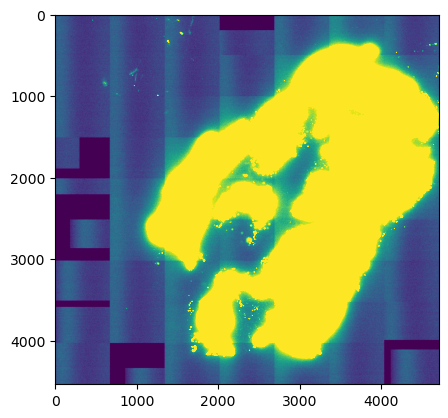

In [108]:
# visualize one channel at a time
plt.imshow(pixels_array[1,0,:,:], vmin=0, vmax=500)
plt.show()

In [155]:
# convert file to xarray DataArray with 3 dimensions: y, x, and marker, datatype can be uint16
pixels_array_df = xr.DataArray(np.reshape(pixels_array, newshape = (80, 4536, 4704)).transpose(1, 2, 0), 
                               dims = ("y", "x", "markers"), 
                               coords = {"y": np.arange(4536, dtype = np.uint16), 
                                         "x": np.arange(4704, dtype = np.uint16), 
                                         'markers': markers})
# save file to netcdf format with zlib compression
pixels_array_df.to_netcdf("/data/srlab1/lakshay-yakir/uc/uc-data/raw/reg001_montage.cdf")

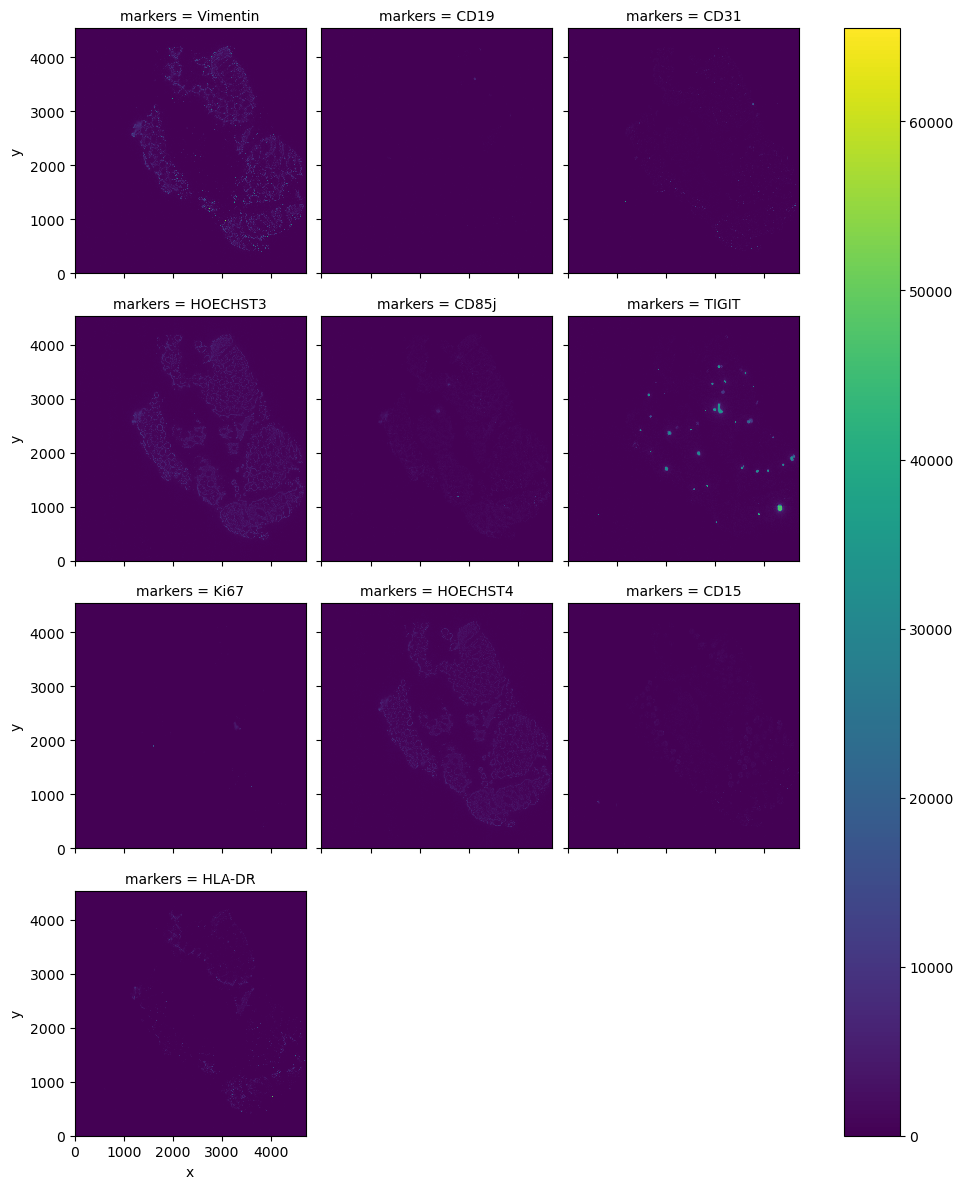

In [156]:
# once in xarray data format, use plot(col='marker') function to make a plot that's faceted by marker
# (but do it for only a subset of the 80 markers o/w will take forever)
test = pixels_array_df.sel(markers=markers[5:15])
test.plot(col = 'markers', col_wrap = 3)

In [161]:
# convert all files to xarray
files = glob.glob("/data/srlab1/lakshay-yakir/uc/uc-data/raw/*/*.tif")

dataset = xr.Dataset() 
for file in files: 
    da = tifffile.TiffFile(file)
    da = file_da.asarray().astype(uint16)
    pixels_array_df = xr.DataArray(np.reshape(file_da, newshape = (-1, da.shape[2], da.shape[3])).transpose(1, 2, 0), 
                               dims = ("y", "x", "markers"), 
                               coords = {"y": np.arange(da.shape[2], dtype = np.float32),
                                         "x": np.arange(da.shape[3], dtype = np.float32),
                                         'markers': markers})
    run = os.path.dirname(file)
    reg_file = os.path.basename(file) 
    dataset[f"{run}_{reg_file}"] = pixels_array_df

In [ ]:
# download all files (outside notebook)

# to-do
## downsampling:
2) figure out if downsampling code below is faster then using opencv2
3) write clean downsampling function for an xarray and push to tpae.ingest
4) delete all code above and replace with one loop that reads all files, downsamples them to 10u, adds 'sid' and 'donor' to s.attrs, and saves to f'{data_dir}/10u/counts' (with compression={'zlib': True, 'complevel': 2} # settings for writing xarrays)
5) choose your favorite marker and make a plot of that marker across all samples at the 10u resolution

## identification of tissue:
1) adapt code below to determine tissue mask and produce a plot of total intensity versus foreground mask for all samples. (and if it looks bad think about how to make it better.)

In [ ]:
# downsampling code
def downsample(sample, factor, aggregate=np.mean):
    pad_width = ((sample.shape[0] % factor, 0), (sample.shape[1] % factor, 0), (0,0))
    sample = np.pad(sample, pad_width, mode='constant', constant_values=0)
    
    smaller = sample.reshape(sample.shape[0], sample.shape[1]//factor, factor, sample.shape[2])
    smaller = aggregate(smaller, axis=2)
    smaller = smaller.reshape(smaller.shape[0]//factor, factor, smaller.shape[1], smaller.shape[2])
    smaller = aggregate(smaller, axis=1)
    return smaller

for f in glob.glob('../BHAM-data/_qptiff/*.qptiff'):
    print('reading', f)
    sample = np.ascontiguousarray(tifffile.TiffFile(f).series[0].asarray().transpose(1,2,0))
    sid = f.split('/')[-1].split('.qptiff')[0]
    print('sid:', sid)
    print('sample shape:', sample.shape)
    
    print('downsampling')
    sample = downsample(sample, downsample_factor)
    np.save(f'{pixelsoutdir}/{sid}.npy', sample)
    print('sample shape:', sample.shape)
    
    gc.collect()
    print()

In [ ]:
# foreground selection code
import cv2 as cv2

sample = np.load(f)
print('sample shape:', sample.shape)

# determine which pixels are non-empty
totals = sample[:,:,:-1].sum(axis=2) - sample[:,:,-1] # (subtracting off AF channel)
totals -= totals.min()
totals /= (totals.max()/255)
totals = totals.astype('uint8')
blurred = cv2.GaussianBlur(totals,(blur_width, blur_width),0)
_, mask = cv2.threshold(blurred,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
mask = mask.astype('bool')
print('npixels:', mask.sum())